In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import os
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import time


2025-06-24 15:14:36.483670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 15:14:36.483781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 15:14:36.574583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 15:14:36.755357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 15:14:38.250637: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf

# Verificar si detecta GPUs
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-24 15:14:42.407899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-24 15:14:42.710102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-24 15:14:42.710329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
base_dir = './Banana Ripeness Classification Dataset V2'
print(os.listdir(base_dir))

['train', 'valid', 'test']


In [4]:
lr ="001"
Et = "10"
l_rate = 0.001
Epoch_test = 10

In [5]:
def save_test_accuracy(experiment_name, test_accuracy, filename='test_accuracy_log.csv'):
    new_entry = pd.DataFrame([{
        'experiment': experiment_name,
        'test_accuracy': test_accuracy
    }])

    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        # Eliminar cualquier fila con el mismo experimento
        df_existing = df_existing[df_existing['experiment'] != experiment_name]
        # Agregar nueva entrada
        df_combined = pd.concat([df_existing, new_entry], ignore_index=True)
    else:
        df_combined = new_entry

    df_combined.to_csv(filename, index=False)
    print(f"Test accuracy for '{experiment_name}' saved to '{filename}'.")

In [6]:
image_size = (299, 299)  # Tamaño compatible con xception
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Importante para la matriz de confusión
)


Found 9440 images belonging to 4 classes.
Found 2023 images belonging to 4 classes.
Found 2015 images belonging to 4 classes.


In [7]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

# Igual que antes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases como antes

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-06-24 15:14:43.057795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-24 15:14:43.058039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-24 15:14:43.058135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [8]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_generator,
      epochs=Epoch_test,
      validation_data=valid_generator,
  )

Epoch 1/10


2025-06-24 15:14:49.040114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-24 15:14:51.646104: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f51d0d3e1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-24 15:14:51.646158: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-06-24 15:14:51.663619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750778091.781903     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 [==============================] - 205s 677ms/step - loss: 0.3476 - accuracy: 0.8774 - val_loss: 0.1610 - val_accuracy: 0.9496
Epoch 2/10
295/295 [==============================] - 196s 665ms/step - loss: 0.2288 - accuracy: 0.9193 - val_loss: 0.1374 - val_accuracy: 0.9550
Epoch 3/10
295/295 [==============================] - 171s 578ms/step - loss: 0.1865 - accuracy: 0.9334 - val_loss: 0.0932 - val_accuracy: 0.9748
Epoch 4/10
295/295 [==============================] - 146s 496ms/step - loss: 0.1761 - accuracy: 0.9357 - val_loss: 0.1060 - val_accuracy: 0.9634
Epoch 5/10
295/295 [==============================] - 140s 474ms/step - loss: 0.1604 - accuracy: 0.9414 - val_loss: 0.0910 - val_accuracy: 0.9728
Epoch 6/10
295/295 [==============================] - 140s 475ms/step - loss: 0.1489 - accuracy: 0.9457 - val_loss: 0.0827 - val_accuracy: 0.9733
Epoch 7/10
295/295 [==============================] - 142s 480ms/step - loss: 0.1446 - accuracy: 0.9494 - val_loss: 0.0892 - val_accura

In [9]:
fine_tune_at = 100  # últimas 30 capas aprox
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [10]:
for layer in base_model.layers:
    if 'exit' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-5),  # más bajo que antes
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
with tf.device('/GPU:0'):
    history_finetune = model.fit(
        train_generator,
        epochs= 5,
        validation_data = valid_generator,
    )

Epoch 1/5
295/295 [==============================] - 146s 488ms/step - loss: 0.1182 - accuracy: 0.9582 - val_loss: 0.0707 - val_accuracy: 0.9748
Epoch 2/5
295/295 [==============================] - 144s 487ms/step - loss: 0.1113 - accuracy: 0.9605 - val_loss: 0.0680 - val_accuracy: 0.9768
Epoch 3/5
295/295 [==============================] - 140s 474ms/step - loss: 0.1072 - accuracy: 0.9619 - val_loss: 0.0651 - val_accuracy: 0.9773
Epoch 4/5
295/295 [==============================] - 140s 474ms/step - loss: 0.1074 - accuracy: 0.9620 - val_loss: 0.0634 - val_accuracy: 0.9797
Epoch 5/5
295/295 [==============================] - 141s 477ms/step - loss: 0.1099 - accuracy: 0.9625 - val_loss: 0.0616 - val_accuracy: 0.9787


63/63 [==============================] - 15s 236ms/step
Classification Report
              precision    recall  f1-score   support

    overripe       1.00      0.98      0.99       479
        ripe       0.96      0.97      0.97       520
      rotten       0.98      0.97      0.97       541
      unripe       0.97      1.00      0.98       475

    accuracy                           0.98      2015
   macro avg       0.98      0.98      0.98      2015
weighted avg       0.98      0.98      0.98      2015

Confusion Matrix


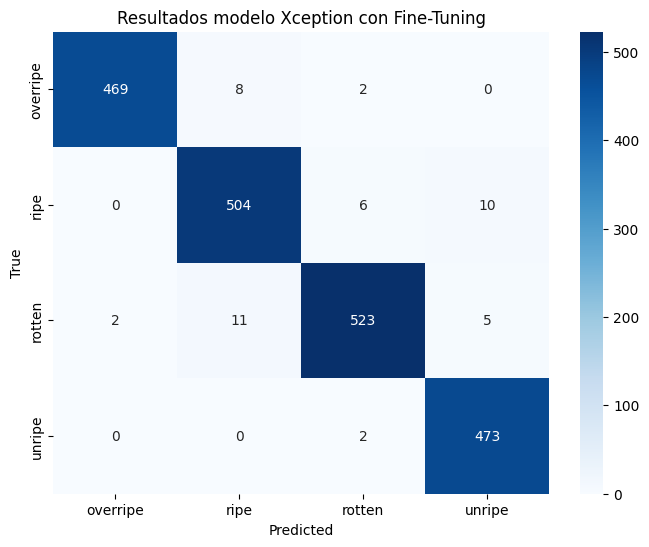

In [13]:
# Predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Reporte y matriz de confusión
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.title(f"Resultados modelo Xception con Fine-Tuning")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'Matrices de confusion/FT/matriz_confusion_xception.png', bbox_inches='tight')
plt.show()


In [14]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(test_generator.classes, y_pred)
experiment_name = f'xception_FT'

save_test_accuracy(experiment_name, test_accuracy, "accurasy_fine_tuning.csv")

Test accuracy for 'xception_FT' saved to 'accurasy_fine_tuning.csv'.


In [15]:
model.save(f'modelos/XCEPTION_FT.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
